In [1]:
#Imports

import numpy as np
import matplotlib.pyplot as plt
import hera_cal.abscal as abscal
import uvtools.dspec as dspec 
import hera_pspec
from hera_pspec import pspecbeam
from hera_pspec import pspecdata
import itertools
import scipy 
from scipy import signal
import pickle
import copy
from hera_cal.utils import polnum2str, polstr2num, jnum2str, jstr2num
from hera_cal.io import HERAData, HERACal
from hera_cal.io import DataContainer 
from hera_cal import apply_cal
from hera_cal import io
from hera_cal import smooth_cal
from hera_cal import vis_clean
from hera_cal import redcal
from pyuvdata import UVFlag
import glob
import tqdm
import os
import shutil

/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/users/kshahin/miniconda2/envs/hera3/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next maj

In [2]:
%config Completer.use_jedi = False

In [3]:
#Scale Plot/Figure Sizes

plt.rcParams['figure.figsize'] = 20,10
plt.rcParams['font.size'] = 20

In [4]:
#Discrete Fourier Transform 

def fft(x):
    return np.abs(np.fft.fftshift(np.fft.fft(np.fft.fftshift(x))))

In [5]:
flag_files = [f"H1C_Flags/{jd}.flags.h5" for jd in [2458104,2458105,2458109,2458112,2458113,2458114,2458115,2458116]]
model_files = sorted(glob.glob('/lustre/aoc/projects/hera/aewallwi/time_dep_flagging/2458098/*.true.uvh5'))
data_files = sorted(glob.glob('/lustre/aoc/projects/hera/aewallwi/time_dep_flagging/2458098/*.true.uvh5'))

In [6]:
ntimes = []
for flags in flag_files:
    uvf = UVFlag(flags)
    ntimes.append(uvf.Ntimes)
nflagstimes = np.min(ntimes)

There are 33 antennas and they are: [ 0  1  2 11 12 13 14 23 24 25 26 27 36 37 38 39 40 41 50 51 52 53 54 55
 66 67 68 69 70 83 84 85 86]

There are 1024 frequencies, covering a range of 100.0 MHz to 200.0 MHz.

There are 60 time inteMagrations.
1. The width of each frequency channel is 0.09775171065492928 MHz.

2. The Julian Dates range from 2458098.2970820144 to 2458098.3044142793

3. The integration time is 10.737419128417969 seconds.

4. The LSTs range from 1.87175688966871 to 2.0482130396260514 hours.

5. There are 1122 baselines but there should be N*(N-1)/2*4 = 2112


Text(0.5, 1.0, 'HERA-19 Antenna Positions')

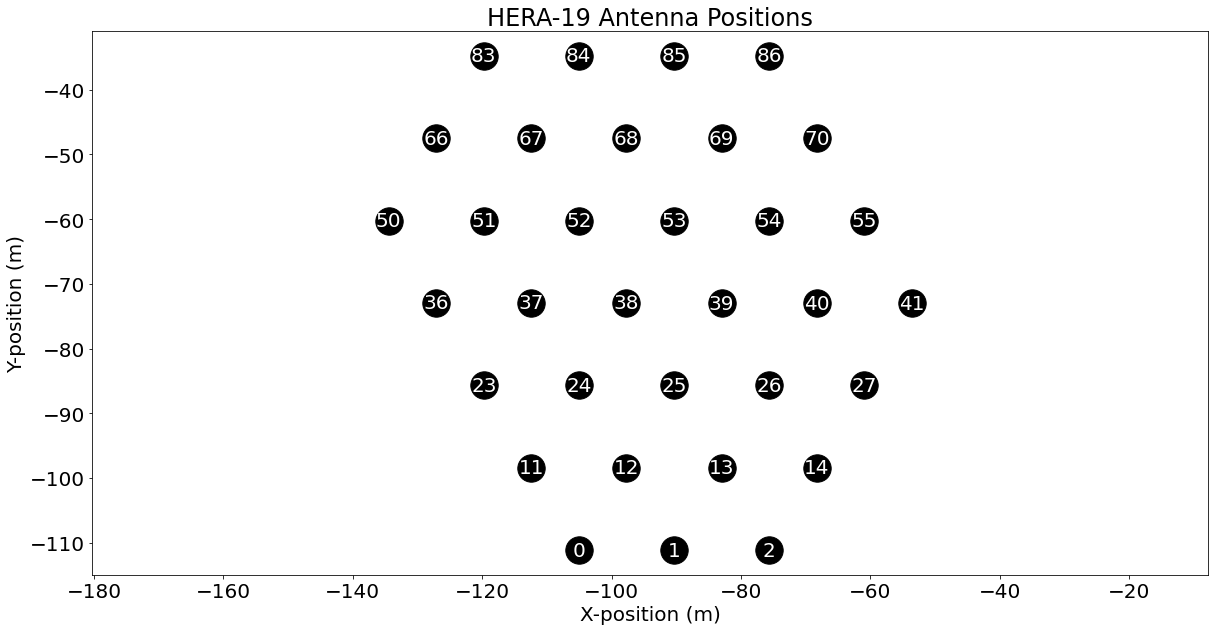

In [44]:
print('There are', len(hd.ants), 'antennas and they are:', hd.ants)

print('\nThere are', len(hd.freqs), 'frequencies, covering a range of',
      np.min(hd.freqs) / 1e6, 'MHz to', np.max(hd.freqs) / 1e6,'MHz.')

print('\nThere are', len(hd.times), 'time inteMagrations.')

print('1. The width of each frequency channel is', (hd.freqs[1] - hd.freqs[0]) / 1e6, 'MHz.')

print('\n2. The Julian Dates range from', np.min(hd.times), 'to', np.max(hd.times))

print('\n3. The integration time is', np.median(np.diff(hd.times)) * 24 * 3600, 'seconds.')

print('\n4. The LSTs range from', np.min(hd.lsts)*12/np.pi, 'to', np.max(hd.lsts)*12/np.pi, 'hours.')

print('\n5. There are', len(hd.bls), 'baselines but there should be N*(N-1)/2*4 =', 
      int(len(hd.ants)*(len(hd.ants)-1)/2*4))


xs = [hd.antpos[ant][0] for ant in hd.ants]
ys = [hd.antpos[ant][1] for ant in hd.ants]

plt.figure()
plt.scatter(xs, ys, marker='.', color='k', s=3000) # plot the antenna positions with black circles
for i, ant in enumerate(hd.ants): # loop over antennas
    plt.text(xs[i], ys[i], ant, color='w', va='center', ha='center') # label antenna numbers
plt.xlabel('X-position (m)')
plt.ylabel('Y-position (m)')
plt.axis('equal');
plt.title("HERA-19 Antenna Positions")
#plt.savefig('HERA_antpos.pdf')

In [1]:
#For-Loop Calibration (LAST 5 DAYS)
nfiles = []
for dayt,flag_file in enumerate(flag_files[5:]):
    day = dayt + 5 
    if not os.path.exists(f'HERA_CLEAN_NOPRISIM_FULL_{day}'):
        os.mkdir(f'HERA_CLEAN_NOPRISIM_FULL_{day}')
    hdlst = io.HERAData(data_files)
    lsts = np.unique(np.hstack(list(hdlst.lsts.values())))
    dlst = np.mean(np.diff(lsts))
    flags = UVFlag(flag_file)
    flags.select(frequencies = flags.freq_array[(flags.freq_array>=115*1e+6) & (flags.freq_array<175*1e+6)])
    flags.select(times=flags.time_array[(flags.lst_array>=lsts.min()-dlst/2) & (flags.lst_array<=lsts.max()+dlst/2)])
    flags_chunks = [flags.flag_array.squeeze()[i*60:(i+1)*60] for i in range(nflagstimes//60)]
    for c in range(len(flags_chunks)):
        if flags_chunks[c].shape[0]<60:
            npad = 60 - flags_chunks[c].shape[0]
            flags_chunks[c] = np.vstack([flags_chunks[c], np.ones((npad,flags_chunks[c].shape[1]), dtype=bool)])
    file_number=0
    for data_file,model_file,flags_chunk in tqdm.tqdm(zip(data_files, model_files, flags_chunks)):
        #Opening Data/Flags
        hd_data = HERAData(data_file)     
        freqs = hd_data.freqs[(hd_data.freqs>=115*1e+6) & (hd_data.freqs<175*1e+6)]
        d_data, d_flags, d_nsamples = hd_data.read(polarizations=['nn'], frequencies=freqs)
        for bl in d_data:
            d_flags[bl] = flags_chunk
        hd_data.update(flags=d_flags)
        hd_data.write_uvh5(f"HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5", clobber=True)
        del d_data,d_flags,d_nsamples,hd_data
        #Calculate Gains/Smooth
        redcal.redcal_run(input_data=f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5',
                          clobber=True, solar_horizon=90, verbose=True)
        abscal.post_redcal_abscal_run(data_file = f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5',
                                      redcal_file = f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.omni.calfits',
                                      model_files = [f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5'],
                                      clobber=True, data_solar_horizon=90,
                                      model_solar_horizon=90)
        file_number += 1
    nfiles.append(file_number)
    cs = smooth_cal.CalibrationSmoother(calfits_list=sorted(glob.glob(f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_*.abs.calfits')))
    cs.time_freq_2D_filter(time_scale=21600)
    cs.write_smoothed_cal(clobber=True,output_replace=('.abs.','.smooth_abs.'))
    
    for file_number in tqdm.tqdm(range(nfiles[-1])): 
        #Apply Smooth Gains
        apply_cal.apply_cal(data_infilename=f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5',
                            data_outfilename=f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}_smoothcal.uvh5',
                            new_calibration=f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.smooth_abs.calfits', clobber=True)
        #Fourier-Filter
        vc = vis_clean.VisClean(f"HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}_smoothcal.uvh5")
        vc.read()
        vc.vis_clean(standoff=100, min_dly=600, mode='dpss_leastsq', skip_if_flag_within_edge_distance=1, 
                     flag_model_rms_outliers=True, max_contiguous_edge_flags=1)
        vc.write_filtered_data(filled_outfilename=f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}_filtered.uvh5',clobber=True)
        os.remove(f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5')

In [2]:
#For-Loop Calibration
nfiles = []
for day,flag_file in enumerate(flag_files):
    if not os.path.exists(f'HERA_CLEAN_NOPRISIM_FULL_{day}'):
        os.mkdir(f'HERA_CLEAN_NOPRISIM_FULL_{day}')
    hdlst = io.HERAData(data_files)
    lsts = np.unique(np.hstack(list(hdlst.lsts.values())))
    dlst = np.mean(np.diff(lsts))
    flags = UVFlag(flag_file)
    flags.select(frequencies = flags.freq_array[(flags.freq_array>=115*1e+6) & (flags.freq_array<175*1e+6)])
    flags.select(times=flags.time_array[(flags.lst_array>=lsts.min()-dlst/2) & (flags.lst_array<=lsts.max()+dlst/2)])
    flags_chunks = [flags.flag_array.squeeze()[i*60:(i+1)*60] for i in range(nflagstimes//60)]
    file_number=0
    for data_file,model_file,flags_chunk in tqdm.tqdm(zip(data_files, model_files, flags_chunks)):
        #Opening Data/Flags
        hd_data = HERAData(data_file)     
        freqs = hd_data.freqs[(hd_data.freqs>=115*1e+6) & (hd_data.freqs<175*1e+6)]
        d_data, d_flags, d_nsamples = hd_data.read(polarizations=['nn'], frequencies=freqs)
        for bl in d_data:
            d_flags[bl] = flags_chunk
        hd_data.update(flags=d_flags)
        hd_data.write_uvh5(f"HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5", clobber=True)
        del d_data,d_flags,d_nsamples,hd_data
        #Calculate Gains/Smooth
        redcal.redcal_run(input_data=f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5',
                          clobber=True, solar_horizon=90, verbose=True)
        abscal.post_redcal_abscal_run(data_file = f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5',
                                      redcal_file = f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.omni.calfits',
                                      model_files = [f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5'],
                                      clobber=True, data_solar_horizon=90,
                                      model_solar_horizon=90)
        file_number += 1
    nfiles.append(file_number)
    cs = smooth_cal.CalibrationSmoother(calfits_list=sorted(glob.glob(f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_*.abs.calfits')))
    cs.time_freq_2D_filter(time_scale=21600)
    cs.write_smoothed_cal(clobber=True,output_replace=('.abs.','.smooth_abs.'))
    
    for file_number in tqdm.tqdm(range(nfiles[-1])): 
        #Apply Smooth Gains
        apply_cal.apply_cal(data_infilename=f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5',
                            data_outfilename=f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}_smoothcal.uvh5',
                            new_calibration=f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.smooth_abs.calfits', clobber=True)
        #Fourier-Filter
        vc = vis_clean.VisClean(f"HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}_smoothcal.uvh5")
        vc.read()
        vc.vis_clean(standoff=100, min_dly=600, mode='dpss_leastsq', skip_if_flag_within_edge_distance=1, 
                     flag_model_rms_outliers=True, max_contiguous_edge_flags=1)
        vc.write_filtered_data(filled_outfilename=f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}_filtered.uvh5',clobber=True)
        os.remove(f'HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}.uvh5')

In [3]:
nfiles_min = 32
if not os.path.exists(f'HERA_CLEAN_NOPRISIM_FULL_averagebeforefilter'):
        os.mkdir(f'HERA_CLEAN_NOPRISIM_FULL_averagebeforefilter')
#Average Before Filter
for file_number in range(nfiles_min):
    for day in range(len(flag_files)):
        cfile = f"HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}_smoothcal.uvh5"
        hd = HERAData(cfile)
        data_t,flags_t,nsamples_t = hd.read()
        if day==0:
            data_avg=DataContainer({bl:data_t[bl]*nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
            flags_avg =DataContainer({bl:flags_t[bl] for bl in data_t})
            nsamples_avg = DataContainer({bl:nsamples_t[bl]*(~flags_t[bl]) for bl in data_t})
        else:
            for bl in data_avg:
                data_avg[bl] = data_avg[bl] + data_t[bl]*nsamples_t[bl]*(~flags_t[bl])
                flags_avg[bl] = flags_avg[bl] & flags_t[bl]
                nsamples_avg[bl] = nsamples_avg[bl] + nsamples_t[bl]*(~flags_t[bl])
    for bl in data_avg:   
        data_avg[bl] = data_avg[bl]/nsamples_avg[bl]
        data_avg[bl][~np.isfinite(data_avg[bl])] = 0.0
    hd.update(data=data_avg, flags=flags_avg, nsamples=nsamples_avg)
    hd.write_uvh5(f'HERA_CLEAN_NOPRISIM_FULL_averagebeforefilter/data_avg_{file_number}.uvh5', clobber=True)

In [4]:
#Fourier-Filter (VisClean)(NEW)
for file_number in range(nfiles_min):
    vc = vis_clean.VisClean(f'HERA_CLEAN_NOPRISIM_FULL_averagebeforefilter/data_avg_{file_number}.uvh5')
    vc.read()
    vc.vis_clean(standoff=100, min_dly=600, mode='dpss_leastsq', skip_if_flag_within_edge_distance=1,
                 flag_model_rms_outliers=True, max_contiguous_edge_flags=1)
    vc.write_filtered_data(filled_outfilename=f'HERA_CLEAN_NOPRISIM_FULL_averagebeforefilter/data_avg_{file_number}_filtered.uvh5',
                           clobber=True)

In [5]:
if not os.path.exists(f'HERA_CLEAN_NOPRISIM_FULL_averageafterfilter'):
        os.mkdir(f'HERA_CLEAN_NOPRISIM_FULL_averageafterfilter')
#Average After Filter
for file_number in range(nfiles_min):
    for day in range(len(flag_files)):
        ffile = f"HERA_CLEAN_NOPRISIM_FULL_{day}/data_{day}_{file_number}_filtered.uvh5"
        hd = HERAData(ffile)
        data_f,flags_f,nsamples_f = hd.read()
        if day==0:
            data_avg=DataContainer({bl:data_f[bl]*nsamples_f[bl]*(~flags_f[bl]) for bl in data_f})
            flags_avg =DataContainer({bl:flags_f[bl] for bl in data_f})
            nsamples_avg = DataContainer({bl:nsamples_f[bl]*(~flags_f[bl]) for bl in data_f})
        else:
            for bl in data_avg:
                data_avg[bl] = data_avg[bl] + data_f[bl]*nsamples_f[bl]*(~flags_f[bl])
                flags_avg[bl] = flags_avg[bl] & flags_f[bl]
                nsamples_avg[bl] = nsamples_avg[bl] + nsamples_f[bl]*(~flags_f[bl])
    for bl in data_avg:   
        data_avg[bl] = data_avg[bl]/nsamples_avg[bl]
        data_avg[bl][~np.isfinite(data_avg[bl])] = 0.0
    hd.update(data=data_avg, flags=flags_avg, nsamples=nsamples_avg)
    hd.write_uvh5(f'HERA_CLEAN_NOPRISIM_FULL_averageafterfilter/data_avg_{file_number}_filtered.uvh5', clobber=True)

Telescope RIMEz calculation is not in known_telescopes.


Text(0, 0.5, 'Simulation Time [s]')

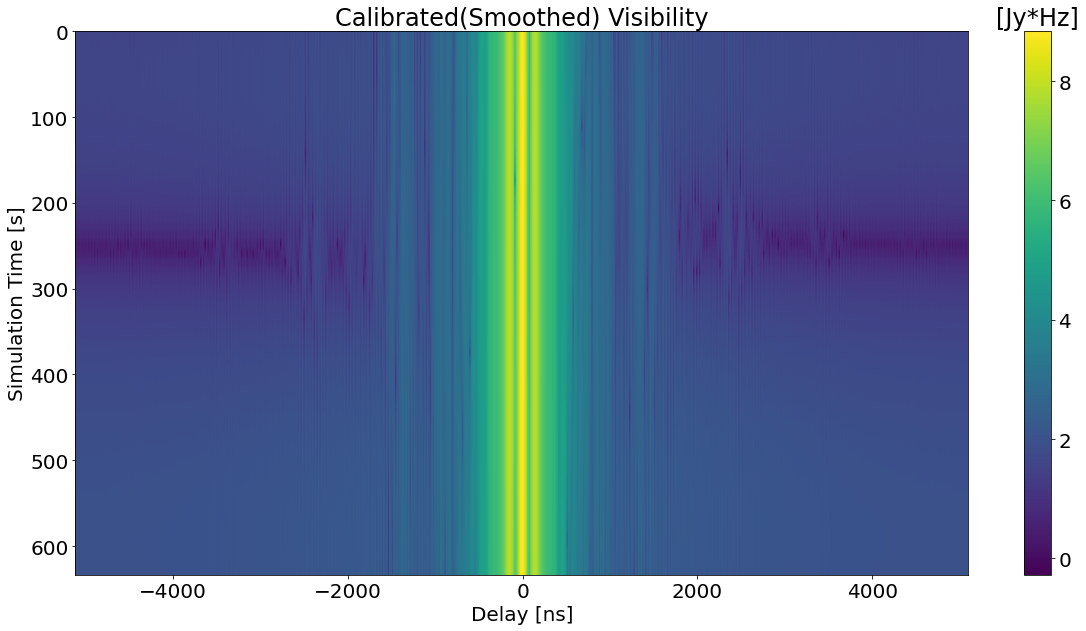

In [26]:
hd = HERAData("HERA_CLEAN_NOPRISIM_FULL_0/data_0_20_smoothcal.uvh5")
data, flags, nsamples = hd.read()
bh = dspec.gen_window('bh',614)
jul = 24*3600             #julian date to seconds
interpolated_times = (hd.times -hd.times.min())*jul
delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),data.freqs[1] - data.freqs[0]))
ext = (delay_blh.min()*1e+9, delay_blh.max()*1e+9, interpolated_times.max(), interpolated_times.min())
ext2 = (data.freqs[0]/1e6, data.freqs[-1]/1e6, interpolated_times.max(), interpolated_times.min())
plt.imshow(np.log10(np.abs(fft(bh*(data[(11, 14, 'nn')]*(data.freqs[1]-data.freqs[0]))))), extent=ext, aspect='auto')
clb = plt.colorbar()
clb.ax.set_title('[Jy*Hz]')
plt.title('Calibrated(Smoothed) Visibility')
plt.xlabel('Delay [ns]')
plt.ylabel('Simulation Time [s]')

Text(0, 0.5, 'Simulation Time [s]')

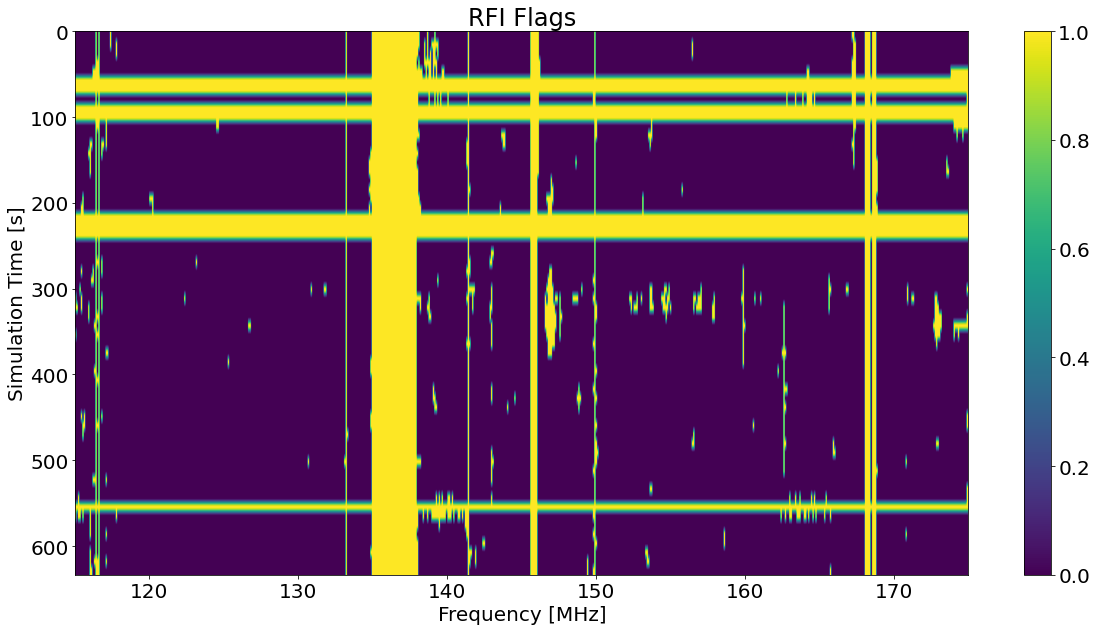

In [25]:
plt.imshow(flags[(11, 14, 'nn')].astype(float), extent=ext2, aspect='auto' )
plt.colorbar()
plt.title("RFI Flags")
plt.xlabel('Frequency [MHz]')
plt.ylabel('Simulation Time [s]')

Telescope RIMEz calculation is not in known_telescopes.
divide by zero encountered in log10


Text(0, 0.5, 'Simulation Time [s]')

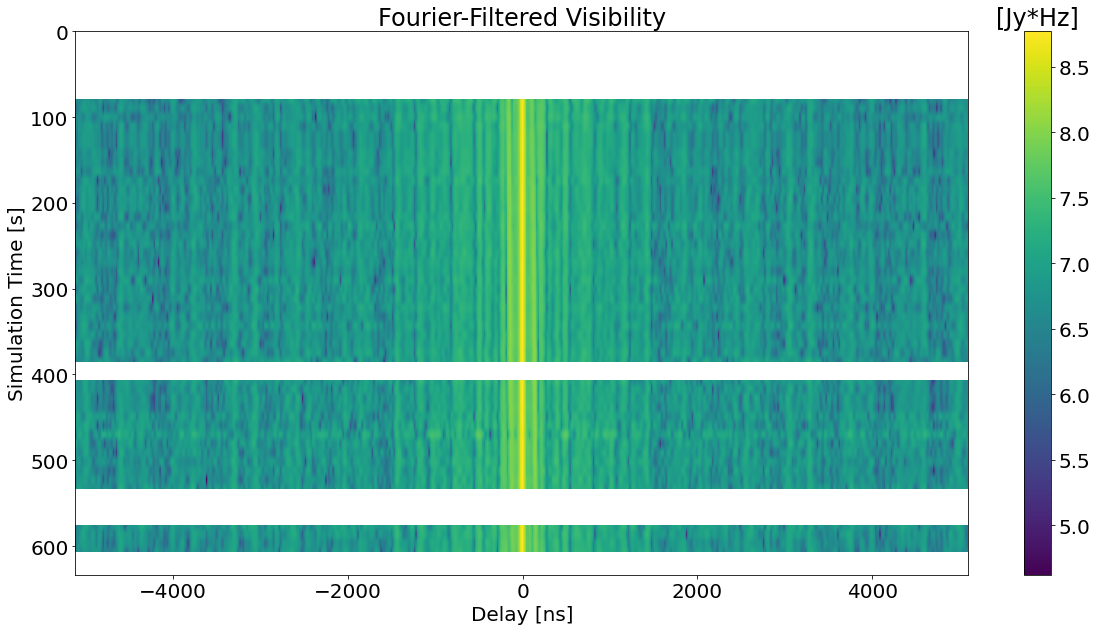

In [27]:
hd = HERAData("HERA_CLEAN_NOPRISIM_0/data_0_20_filtered.uvh5")
data, flags, nsamples = hd.read()
plt.imshow(np.log10(np.abs(fft(bh*(data[(11, 14, 'nn')]*(data.freqs[1]-data.freqs[0]))))), extent=ext, aspect='auto')
clb = plt.colorbar()
clb.ax.set_title('[Jy*Hz]')
plt.title('Fourier-Filtered Visibility')
plt.xlabel('Delay [ns]')
plt.ylabel('Simulation Time [s]')

Telescope RIMEz calculation is not in known_telescopes.
Telescope RIMEz calculation is not in known_telescopes.


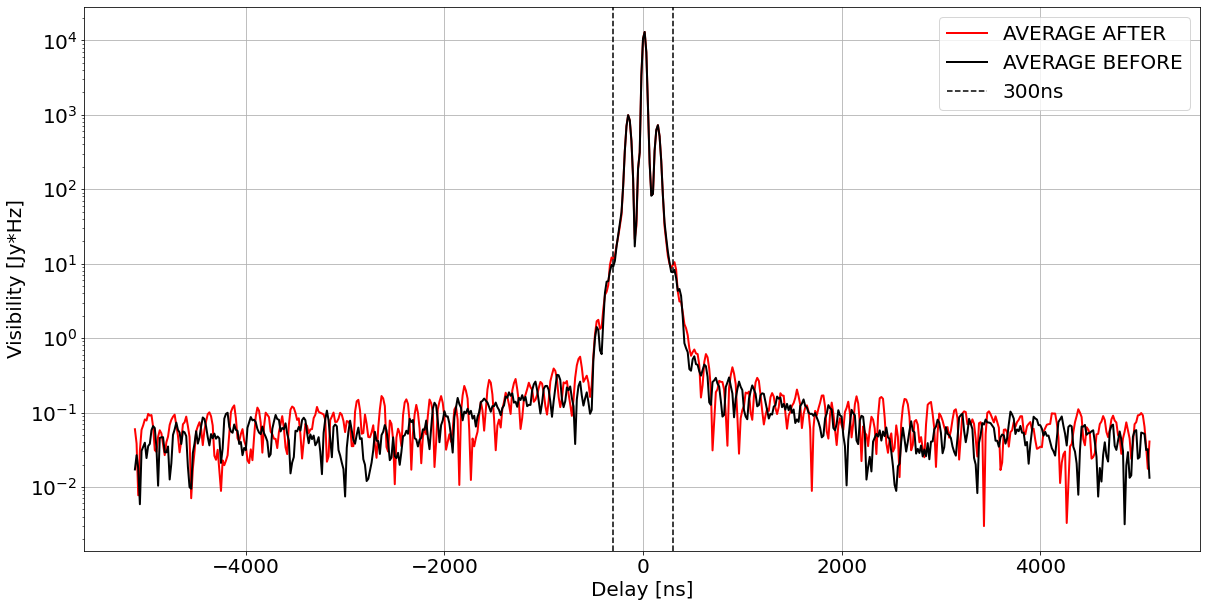

In [29]:
#Average Before Filter vs Average After Filter

file = 'HERA_CLEAN_NOPRISIM_FULL_averageafterfilter/data_avg_10_filtered.uvh5'
hd = HERAData(file)
data_after, flags_after, nsamples_after = hd.read()
file = 'HERA_CLEAN_NOPRISIM_FULL_averagebeforefilter/data_avg_10_filtered.uvh5'
hd = HERAData(file)
data_before, flags_before, nsamples_before = hd.read()


plt.plot(delay_blh*1e+9,fft(bh*(data_after[(11, 14, 'nn')])[10]), label='AVERAGE AFTER', color='red', linewidth=2)
plt.plot(delay_blh*1e+9,fft(bh*(data_before[(11, 14, 'nn')])[10]), label='AVERAGE BEFORE', color='black', linewidth=2)
plt.axvline(300,color='black', linestyle='--', label='300ns')
plt.axvline(-300,color='black', linestyle='--')
plt.xlabel('Delay [ns]')
plt.ylabel('Visibility [Jy*Hz]')

plt.yscale('log')
# plt.title('Fourier-Filtered Calibrated Visibility (Residual+Model)')
plt.grid()
plt.legend()

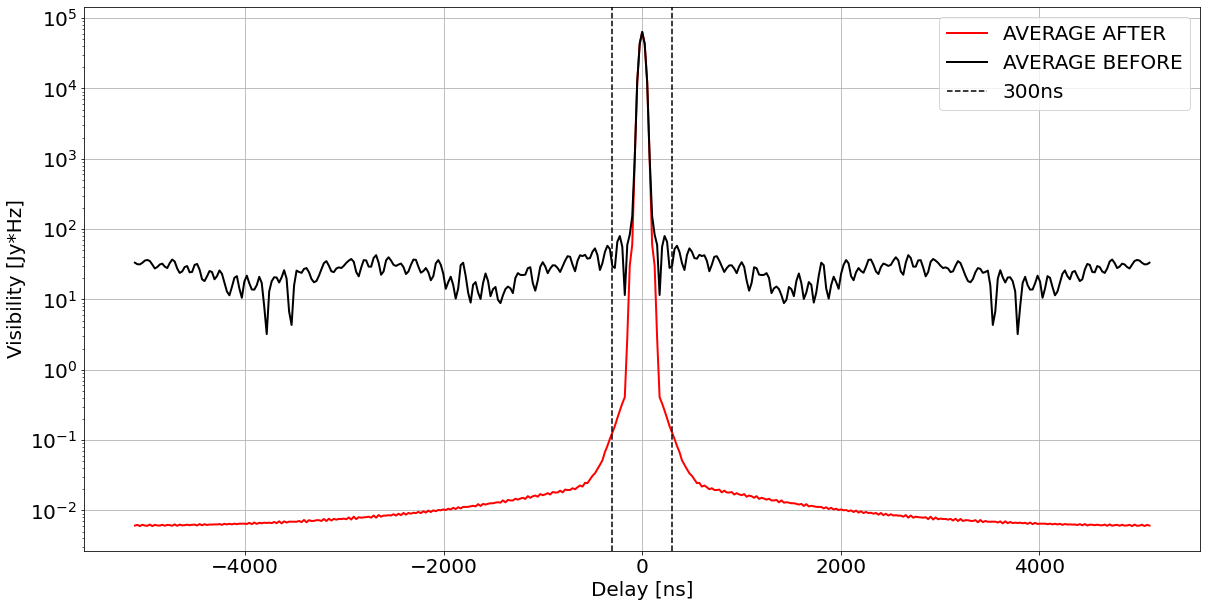

In [32]:
#Average Averages

avg_after = (np.mean(np.abs(data_after[(0,1,'nn')])** 2, axis=0))
avg_before = (np.mean(np.abs(data_before[(0,1,'nn')])** 2, axis=0))


plt.figure()
plt.plot(delay_blh*1e+9,fft(bh*avg_after), label='AVERAGE AFTER', color='red', linewidth=2)
plt.plot(delay_blh*1e+9,fft(bh*avg_before), label='AVERAGE BEFORE', color='black', linewidth=2)
plt.axvline(300,color='black', linestyle='--', label='300ns')
plt.axvline(-300,color='black', linestyle='--')
plt.xlabel('Delay [ns]')
plt.ylabel('Visibility [Jy*Hz]')

plt.yscale('log')
# plt.title('Fourier-Filtered Calibrated Visibility (Residual+Model)')
plt.grid()
plt.legend()

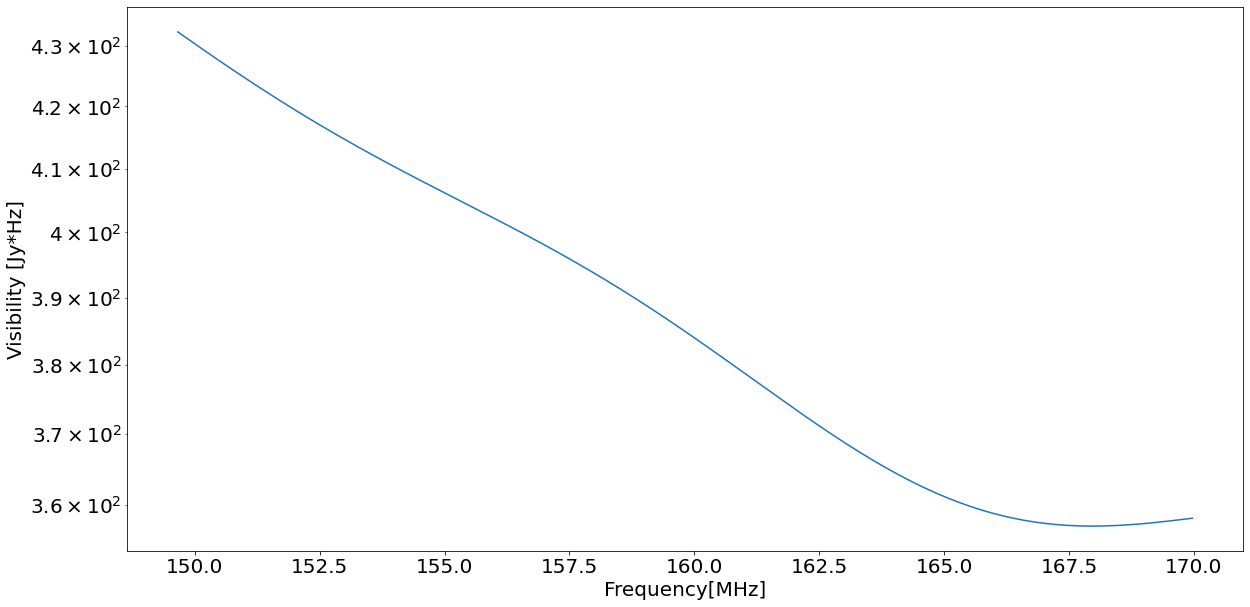

In [49]:
#150-169 MHz

plt.plot(data.freqs[200:409]/1e6, avg_after[200:409], label='AVG AFTER')
plt.ylabel('Visibility [Jy*Hz]')
plt.xlabel('Frequency[MHz]')
plt.yscale('log')

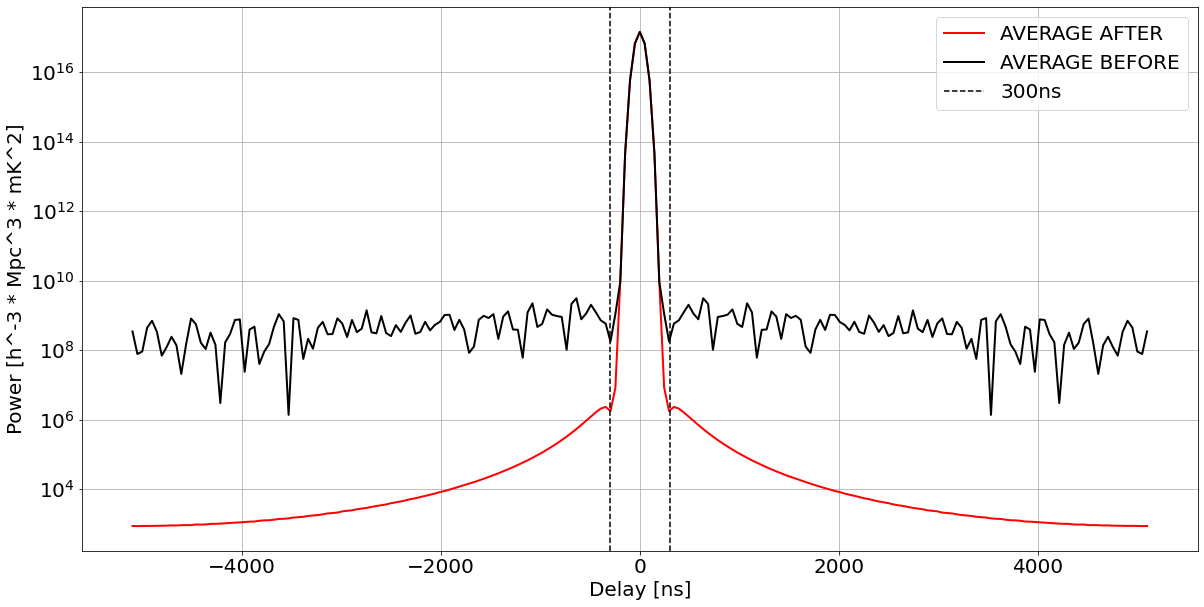

In [13]:
#Average of Average Before/After Fourier-Filtering (150-169MHz)

data.freqs = data.freqs[200:409]
avg_after = avg_after[200:409]
avg_before = avg_before[200:409]
bh = dspec.gen_window('bh',209)
delay_blh = np.fft.fftshift(np.fft.fftfreq(len(bh),data.freqs[1] - data.freqs[0]))

lambda_obs = 2      #150MHz ---> 2m
lambda_emit = 0.21      #0.21m 
z = (lambda_obs - lambda_emit)/lambda_emit  #z=8.5
X2Y = 540*(((1+z)/10)**(0.9))
B = data.freqs.max()-data.freqs.min()  
d = 14           #14m (diameter of dish)
theta = (1.22*(lambda_obs/d))**2
Omega = np.pi*theta**2
k_b = 1.38e-23  #J/K
Power_Transformation = ((X2Y)/(Omega*B))*(((2*k_b)/(lambda_obs**2))**-2)*(1e-52)


avg_after = fft(bh*avg_after)
avg_before = fft(bh*avg_before)

avg_after = (np.abs(avg_after)**2)*Power_Transformation
avg_before = (np.abs(avg_before)**2)*Power_Transformation


plt.plot(delay_blh*1e+9,(avg_after*1e6)*((data.freqs[1]-data.freqs[0])**2), label='AVERAGE AFTER', color='red', linewidth=2)
plt.plot(delay_blh*1e+9,(avg_before*1e6)*((data.freqs[1]-data.freqs[0])**2), label='AVERAGE BEFORE', color='black', linewidth=2)
plt.axvline(300,color='black', linestyle='--', label='300ns')
plt.axvline(-300,color='black', linestyle='--')
plt.xlabel('Delay [ns]')
plt.ylabel('Power [h^-3 * Mpc^3 * mK^2]')

plt.yscale('log')
# plt.title('Fourier-Filtered Calibrated Visibility (Residual+Model)')
plt.grid()
plt.legend()

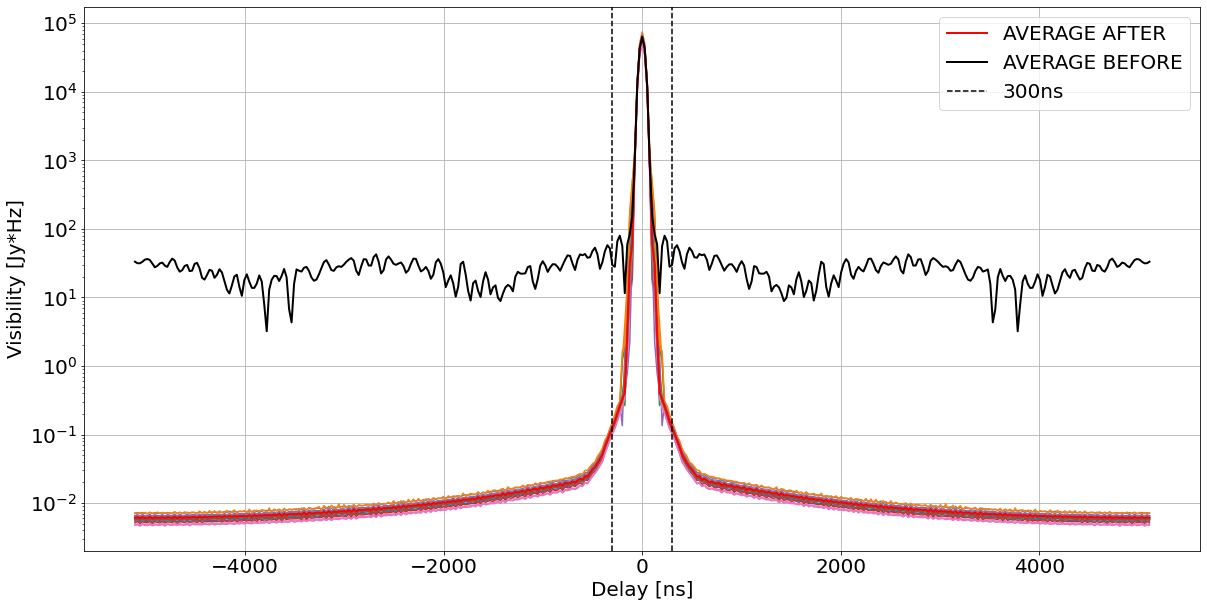

In [77]:
for day in range(18):
    file = f'data_{day}_filtered.uvh5'
    hd = HERAData(file)
    data,flags,nsmaples = hd.read()
    data = np.sum((np.abs(data[(0,1,'nn')])**2)*~flags[(0,1,'nn')], axis=0)/np.sum(~flags[(0,1,'nn')],axis=0)
    plt.plot(delay_blh*1e+9,fft(bh*data))
plt.plot(delay_blh*1e+9,fft(bh*avg_after), label='AVERAGE AFTER', color='red', linewidth=2)
plt.plot(delay_blh*1e+9,fft(bh*avg_before), label='AVERAGE BEFORE', color='black', linewidth=2)
plt.axvline(300,color='black', linestyle='--', label='300ns')
plt.axvline(-300,color='black', linestyle='--')
plt.xlabel('Delay [ns]')
plt.ylabel('Visibility [Jy*Hz]')
plt.yscale('log')
plt.grid()
plt.legend()

In [38]:
file = 'ps_no_halos_z008.46_nf0.581596_useTs1_NX2.0e-01_alphaX1.5_TvirminX2.0e+05_aveTb001 (1).53_Pop2_1024_1600Mpc_v3'
delta_21 = np.loadtxt(file, usecols=1)
k = np.loadtxt(file,usecols=0)